In [1]:
import pandas as pd
from fbprophet import Prophet
from lstm_utils import get_raw_data

Using TensorFlow backend.
C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py:936: DeprecationWarning: builtin type EagerTensor has no __module__ attribute
  EagerTensor = c_api.TFE_Py_InitEagerTensor(_EagerTensorBase)
C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\tensorflow\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Set Parameters

In [3]:
TRAIN_PERCENT = 0.95
STOCK_INDEX = '^GSPC'

## Getting Data

In [7]:
import datetime

start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2018, 8, 12)

sp_df = get_raw_data(STOCK_INDEX, start, end)

In [65]:
sp_df_week = sp_df.resample('W', fill_method='ffill')

C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  """Entry point for launching an IPython kernel.


In [66]:
sp_df_week.head()

,High,Low,Open,Close,Volume,Adj Close
1970-01-04,93.540001,91.790001,92.059998,93.000000,8050000.0,93.000000
1970-01-11,93.250000,91.820000,92.680000,92.400002,9380000.0,92.400002
1970-01-18,92.489998,90.360001,91.680000,90.919998,11940000.0,90.919998
1970-01-25,90.449997,88.739998,90.040001,89.370003,11000000.0,89.370003
1970-02-01,86.330002,84.419998,85.690002,85.019997,12320000.0,85.019997


## Preprocessing Data

In [67]:
# reset index to get date_time as a column
prophet_df = sp_df_week.reset_index()

# prepare the required dataframe
prophet_df.rename(columns={'index':'ds','Close':'y'},inplace=True)
prophet_df = prophet_df[['ds','y']]

In [68]:
# prepare train and test sets
train_size = int(prophet_df.shape[0]-52)
print("Total %d train size %d" % (prophet_df.shape[0], train_size))
train_df = prophet_df.iloc[:train_size]
test_df = prophet_df.iloc[train_size+1:]

Total 2537 train size 2485


## Prepare Prophet Model

In [75]:
# build a prophet model
pro_model = Prophet()

## Fit the Model

In [76]:
# fit the model
pro_model.fit(train_df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\tensorflow\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


## Forecast

In [77]:
# prepare a future dataframe
test_dates = pro_model.make_future_dataframe(periods=test_df.shape[0], freq='W')

# forecast values
forecast_df = pro_model.predict(test_dates)

In [78]:
forecast_df.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
2531,2018-07-08,2337.841755,2327.628865,2347.394740,2203.779407,2490.984928,5.480832,5.480832,5.480832,0.0,0.0,0.0,-1.760391,-1.760391,-1.760391,7.241223,7.241223,7.241223,2343.322587
2532,2018-07-15,2340.267612,2329.388930,2350.677332,2213.797137,2491.885259,7.660139,7.660139,7.660139,0.0,0.0,0.0,-1.760391,-1.760391,-1.760391,9.420530,9.420530,9.420530,2347.927750
2533,2018-07-22,2342.693468,2330.525567,2353.835318,2213.445761,2494.546682,7.295069,7.295069,7.295069,0.0,0.0,0.0,-1.760391,-1.760391,-1.760391,9.055459,9.055459,9.055459,2349.988537
2534,2018-07-29,2345.119325,2332.026168,2356.503571,2197.635816,2495.579615,4.535928,4.535928,4.535928,0.0,0.0,0.0,-1.760391,-1.760391,-1.760391,6.296319,6.296319,6.296319,2349.655254
2535,2018-08-05,2347.545182,2333.564219,2359.487285,2201.402535,2491.511861,1.072477,1.072477,1.072477,0.0,0.0,0.0,-1.760391,-1.760391,-1.760391,2.832867,2.832867,2.832867,2348.617659


## Plot Test Predictions

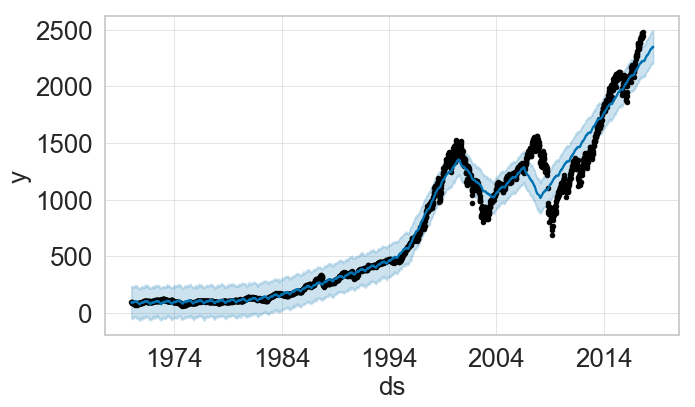

In [79]:
pro_model.plot(forecast_df)
plt.show()

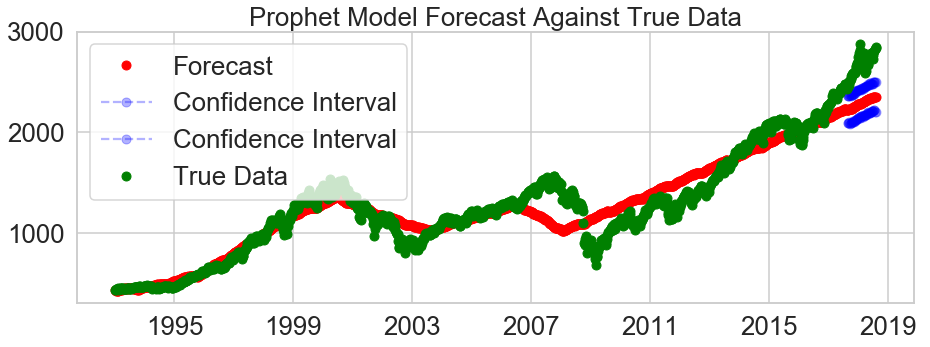

In [80]:
# plot against true data
plt.plot_date(forecast_df.ds.iloc[1200:], forecast_df.yhat.iloc[1200:], c='r',label='Forecast')
plt.plot_date(forecast_df.ds.iloc[train_size+1:], forecast_df.yhat_lower.iloc[train_size+1:],
         linestyle='--',c='b',alpha=0.3,
         label='Confidence Interval')
plt.plot_date(forecast_df.ds.iloc[train_size+1:], forecast_df.yhat_upper.iloc[train_size+1:],
         linestyle='--',c='b',alpha=0.3,
         label='Confidence Interval')
plt.plot_date(prophet_df.ds.iloc[1200:], prophet_df.y.iloc[1200:], c='g', label='True Data')
plt.legend()
plt.title('Prophet Model Forecast Against True Data')
plt.show()

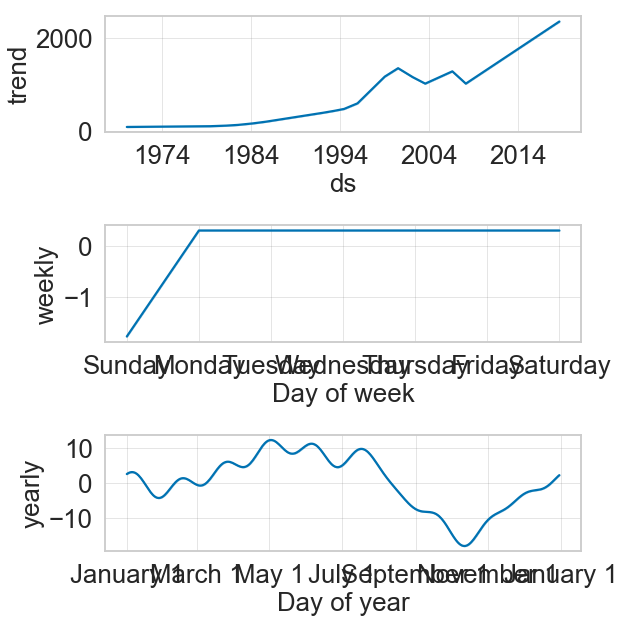

In [81]:
fig = pro_model.plot_components(forecast_df)
